/tmp/ipykernel_52286/520328055.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[f'lag_{lag}'] = train_data['value'].shift(lag)  # Лаговые переменные для обучающих данных
/tmp/ipykernel_52286/520328055.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[f'lag_{lag}'] = test_data['value'].shift(lag)  # Лаговые переменные для тестовых данных
/tmp/ipykernel_52286/520328055.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats

ARIMA RMSE: 4.12
Gradient Boosting Regressor RMSE: 5.95


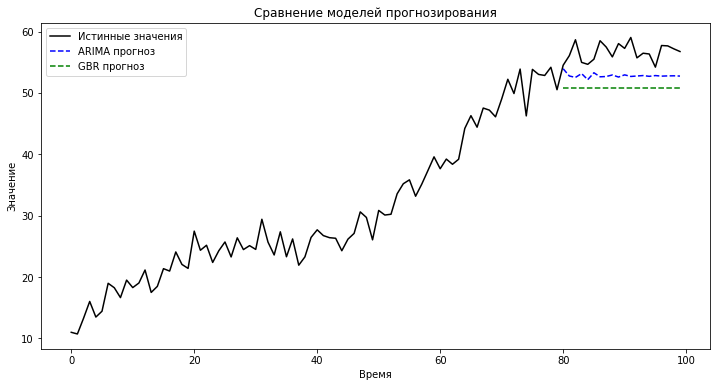

In [1]:
# Импорт необходимых библиотек
import numpy as np  # Для работы с массивами и числовыми операциями
import pandas as pd  # Для работы с таблицами данных (DataFrame)
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV  # Для кросс-валидации и оптимизации гиперпараметров
from sklearn.metrics import mean_squared_error  # Для расчета метрики качества модели (RMSE)
from sklearn.ensemble import GradientBoostingRegressor  # Градиентный бустинг для регрессии
from statsmodels.tsa.arima.model import ARIMA  # ARIMA модель для временных рядов
from sklearn.linear_model import Ridge  # Линейная регрессия с регуляризацией (Ridge)

# Генерация искусственного временного ряда
def generate_synthetic_data():
    np.random.seed(42)  # Устанавливаем фиксированное значение для случайного генератора (повторяемость результатов)
    time = np.arange(100)  # Создаем массив временных точек от 0 до 99
    # Генерируем синтетические данные: линейный тренд + синусоида + шум
    data = 10 + 0.5 * time + 5 * np.sin(0.1 * time) + np.random.normal(scale=2, size=len(time))
    return pd.DataFrame({'time': time, 'value': data})  # Возвращаем данные в формате DataFrame

# Загрузка данных
data = generate_synthetic_data()  # Генерация синтетических временных рядов

# Разделение данных на train/test
train_size = int(len(data) * 0.8)  # 80% данных используем для обучения
train_data = data[:train_size]  # Обучающая выборка
test_data = data[train_size:]  # Тестовая выборка

# Модель ARIMA
arima_model = ARIMA(train_data['value'], order=(5, 1, 0))  # Настраиваем ARIMA модель с указанными параметрами (p, d, q)
arima_fit = arima_model.fit()  # Обучаем модель ARIMA
arima_forecast = arima_fit.forecast(steps=len(test_data))  # Прогнозируем значения на тестовой выборке

# Модель Gradient Boosting Regressor с Grid Search
param_grid = {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}  # Задаем сетку гиперпараметров
gbr = GradientBoostingRegressor()  # Инициализируем модель градиентного бустинга

ts_split = TimeSeriesSplit(n_splits=3)  # Разделяем данные для временной кросс-валидации

# Создаем лаговые переменные
for lag in range(1, 4):  # Создаем лаги (значения предыдущих шагов) для временных рядов
    train_data[f'lag_{lag}'] = train_data['value'].shift(lag)  # Лаговые переменные для обучающих данных
    test_data[f'lag_{lag}'] = test_data['value'].shift(lag)  # Лаговые переменные для тестовых данных
    train_data.fillna(method='bfill', inplace=True)  # Заполняем пропуски ближайшими значениями (backfill)
    test_data.fillna(method='bfill', inplace=True)  # Аналогично для тестовых данных

train_data.dropna(inplace=True)  # Удаляем оставшиеся пропуски

X_train = train_data[['lag_1', 'lag_2', 'lag_3']]  # Фичи для обучающей выборки
y_train = train_data['value']  # Целевая переменная для обучения

X_test = test_data[['lag_1', 'lag_2', 'lag_3']]  # Фичи для тестовой выборки
y_test = test_data['value']  # Целевая переменная для тестирования

# Оптимизация гиперпараметров
grid_search = GridSearchCV(gbr, param_grid, cv=ts_split, scoring='neg_mean_squared_error')  # Настраиваем Grid Search
grid_search.fit(X_train, y_train)  # Обучаем модель с подбором гиперпараметров

# Лучшая модель
best_gbr = grid_search.best_estimator_  # Извлекаем модель с лучшими гиперпараметрами
gbr_forecast = best_gbr.predict(X_test)  # Прогнозируем значения на тестовых данных

# Оценка качества моделей
arima_rmse = np.sqrt(mean_squared_error(y_test, arima_forecast))  # RMSE для модели ARIMA
gbr_rmse = np.sqrt(mean_squared_error(y_test, gbr_forecast))  # RMSE для модели Gradient Boosting Regressor

print(f"ARIMA RMSE: {arima_rmse:.2f}")  # Выводим RMSE для модели ARIMA
print(f"Gradient Boosting Regressor RMSE: {gbr_rmse:.2f}")  # Выводим RMSE для модели GBR

# Визуализация результатов
import matplotlib.pyplot as plt  # Импорт библиотеки для визуализации

plt.figure(figsize=(12, 6))  # Устанавливаем размер графика
plt.plot(data['time'], data['value'], label='Истинные значения', color='black')  # Истинные значения временного ряда
plt.plot(test_data['time'], arima_forecast, label='ARIMA прогноз', linestyle='--', color='blue')  # Прогноз ARIMA
plt.plot(test_data['time'], gbr_forecast, label='GBR прогноз', linestyle='--', color='green')  # Прогноз GBR
plt.legend()  # Отображаем легенду
plt.xlabel('Время')  # Подпись оси X
plt.ylabel('Значение')  # Подпись оси Y
plt.title('Сравнение моделей прогнозирования')  # Заголовок графика
plt.show()  # Отображаем график
